- 所有的graph都是按照GraphTruple 实例作为输入，并返回以GraphTruple作为输出。

- 图跟图之间全局属性，节点属性和边属性的维度要一样的
- 将字典类型的数据通过\[\]进行拼接，然后使用utils_np.data_dicts_to_graph_truple将信息转化为truple.该函数有以下几点作用：
    - 处理节点和边的函数可以并行。
    - 能够计算每个图的节点数和边数，并将其放在n_node和n_edge中，这样他的长度就等于图的数量，而且这样有利于进行分割，让全局的属性广播到属于每一个节点和边。
    - 将节点和边进行拼接，这样索引就会出现偏移。

- 进行简单的图的可视化graphs_tuple是经过data_dicts_to_graph_truple处理过的对象

In [16]:
import numpy as np
import pandas as pd
from graph_nets import *
import networkx as nx
import matplotlib.pyplot as plt

- 字典
data_dict_0 = {
    "globals": globals_0,
    "nodes": nodes_0,
    "edges": edges_0,
    "senders": senders_0,
    "receivers": receivers_0
}


- utils_np.data_dicts_to_graphs_tuple(list of data_dict) 将数据转化为graphs_tuple

- use networkx to build graph_tuple

Text(0.5,1,'Graph')

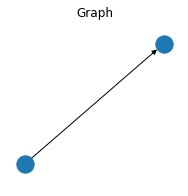

In [17]:
ox = nx.OrderedMultiDiGraph()
ox.graph['features'] = np.array([1,1,1])
ox.add_node(0,features = np.random.random(4))
ox.add_node(1,features = np.random.random(4))
ox.add_edge(0,1,features = np.random.random(4))
graph_tuple = utils_np.networkxs_to_graphs_tuple([ox])
ax = plt.figure(figsize=(3, 3)).gca()
nx.draw(ox, ax=ax)
ax.set_title("Graph")

In [20]:
# 可视化图
import networkx as nx
graphs_nx = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
_, axs = plt.subplots(ncols=2, figsize=(6, 3))
for iax, (graph_nx, ax) in enumerate(zip(graphs_nx, axs)):
  nx.draw(graph_nx, ax=ax)
  ax.set_title("Graph {}".format(iax))
# 打印图的一些信息
def print_graphs_tuple(graphs_tuple):
  print("Shapes of `GraphsTuple`'s fields:")
  print(graphs_tuple.map(lambda x: x if x is None else x.shape, fields=graphs.ALL_FIELDS))
  print("\nData contained in `GraphsTuple`'s fields:")
  print("globals:\n{}".format(graphs_tuple.globals))
  print("nodes:\n{}".format(graphs_tuple.nodes))
  print("edges:\n{}".format(graphs_tuple.edges))
  print("senders:\n{}".format(graphs_tuple.senders))
  print("receivers:\n{}".format(graphs_tuple.receivers))
  print("n_node:\n{}".format(graphs_tuple.n_node))
  print("n_edge:\n{}".format(graphs_tuple.n_edge))

print_graphs_tuple(graphs_tuple)
### networkx 中建立一张图

graph_nx = nx.OrderedMultiDiGraph()
# Globals.
graph_nx.graph["features"] = np.array([0.6, 0.7, 0.8])

# Nodes.
graph_nx.add_node(0, features=np.array([0.3, 1.3]))
graph_nx.add_node(1, features=np.array([0.4, 1.4]))
graph_nx.add_node(2, features=np.array([0.5, 1.5]))
graph_nx.add_node(3, features=np.array([0.6, 1.6]))
# Edges.
graph_nx.add_edge(0, 1, features=np.array([3.6, 3.7]))
graph_nx.add_edge(2, 0, features=np.array([5.6, 5.7]))
graph_nx.add_edge(3, 0, features=np.array([6.6, 6.7]))

ax = plt.figure(figsize=(3, 3)).gca()
nx.draw(graph_nx, ax=ax)
ax.set_title("Graph")

graphs_tuple = utils_np.networkxs_to_graphs_tuple([graph_nx])

print_graphs_tuple(graphs_tuple)

In [37]:
graphs_tuple = utils_np.networkxs_to_graphs_tuple([ox])
GLOBAL_SIZE = 10;NODE_SIZE = 4;EDGE_SIZE = 4;num_nodes = 6;num_edges = 3
data_dict = {
      "globals": np.random.rand(GLOBAL_SIZE).astype(np.float32),
      "nodes": np.random.rand(num_nodes, NODE_SIZE).astype(np.float32),
      "edges": np.random.rand(num_edges, EDGE_SIZE).astype(np.float32),
      "senders": np.random.randint(num_nodes, size=num_edges, dtype=np.int32),
      "receivers": np.random.randint(num_nodes, size=num_edges, dtype=np.int32),
  }
# graph_tuple = utils_np.data_dicts_to_graphs_tuple([data_dict])
graphs_tuple_tf = utils_tf.placeholders_from_data_dicts([data_dict]) # it must be list

In [40]:
import sonnet as snt
import tensorflow as tf

In [44]:
tf.reset_default_graph()
input_graphs = utils_tf.data_dicts_to_graphs_tuple([data_dict])
graph_network = modules.GraphNetwork(
    edge_model_fn=lambda: snt.Linear(output_size=EDGE_SIZE),
    node_model_fn=lambda: snt.Linear(output_size=NODE_SIZE),
    global_model_fn=lambda: snt.Linear(output_size=GLOBAL_SIZE))

num_recurrent_passes = 3
previous_graphs = input_graphs
for unused_pass in range(num_recurrent_passes):
    previous_graphs = graph_network(previous_graphs)
output_graphs = previous_graphs

GraphsTuple(nodes=<tf.Tensor 'graph_network_3/node_block/linear/add:0' shape=(6, 4) dtype=float32>, edges=<tf.Tensor 'graph_network_3/edge_block/linear/add:0' shape=(3, 4) dtype=float32>, receivers=<tf.Tensor 'data_dicts_to_graphs_tuple/add:0' shape=(3,) dtype=int32>, senders=<tf.Tensor 'data_dicts_to_graphs_tuple/add_1:0' shape=(3,) dtype=int32>, globals=<tf.Tensor 'graph_network_3/global_block/linear/add:0' shape=(1, 10) dtype=float32>, n_node=<tf.Tensor 'data_dicts_to_graphs_tuple/stack_2:0' shape=(1,) dtype=int32>, n_edge=<tf.Tensor 'data_dicts_to_graphs_tuple/stack:0' shape=(1,) dtype=int32>)


In [96]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy import spatial
DISTANCE_WEIGHT_NAME = 'distance'

In [102]:
def generate_graph(rand,
                   num_nodes_min_max,
                   dimensions=2,
                   theta=1000.0,
                   rate=1.0):
    # Sample num_nodes.
    num_nodes = rand.randint(*num_nodes_min_max)

    # Create geographic threshold graph.
    pos_array = rand.uniform(size=(num_nodes, dimensions))
    pos = dict(enumerate(pos_array))
    ## sample the weight from exp
    weight = dict(enumerate(rand.exponential(rate, size=num_nodes)))

    ## generate geo_graph https://testfixsphinx.readthedocs.io/en/latest/reference/generated/networkx.generators.geometric.geographical_threshold_graph.html
    ##  undirected and without self-loops
    geo_graph = nx.geographical_threshold_graph(
      num_nodes, theta, pos=pos, weight=weight)

    # Create minimum spanning tree across geo_graph's nodes.
    distances = spatial.distance.squareform(spatial.distance.pdist(pos_array))
    i_, j_ = np.meshgrid(range(num_nodes), range(num_nodes), indexing="ij")
    # ravel 将矩阵展开
    weighted_edges = list(zip(i_.ravel(), j_.ravel(), distances.ravel()))
    mst_graph = nx.Graph()
    mst_graph.add_weighted_edges_from(weighted_edges, weight=DISTANCE_WEIGHT_NAME)
    mst_graph = nx.minimum_spanning_tree(mst_graph, weight=DISTANCE_WEIGHT_NAME)
    # Put geo_graph's node attributes into the mst_graph.
    for i in mst_graph.nodes():
        mst_graph.node[i].update(geo_graph.node[i])

    # Compose the graphs.
    combined_graph = nx.compose_all((mst_graph, geo_graph.copy()))
    # Put all distance weights into edge attributes.
    for i, j in combined_graph.edges():
        combined_graph.get_edge_data(i, j).setdefault(DISTANCE_WEIGHT_NAME,
                                                  distances[i, j])
    return combined_graph, mst_graph, geo_graph

In [103]:
seed = 1  #@param{type: 'integer'}
rand = np.random.RandomState(seed=seed)
import collections
num_examples = 15  #@param{type: 'integer'}
# Large values (1000+) make trees. Try 20-60 for good non-trees.
theta = 20  #@param{type: 'integer'}
num_nodes_min_max = (4,5)

combined_graph, mst_graph, geo_graph = generate_graph(
    rand = rand, num_nodes_min_max = num_nodes_min_max, theta = theta)

In [104]:
print(mst_graph.node,'\n',
      mst_graph.edge,'\n',
      geo_graph.node,'\n',
geo_graph.edge,'\n',
combined_graph.node,'\n',
combined_graph.edge)

{0: {'pos': array([0.417022  , 0.72032449]), 'weight': 0.5054525417107485}, 1: {'pos': array([1.14374817e-04, 3.02332573e-01]), 'weight': 0.7739597748607573}, 2: {'pos': array([0.14675589, 0.09233859]), 'weight': 0.5433393706182451}, 3: {'pos': array([0.18626021, 0.34556073]), 'weight': 1.1558797097094222}} 
 {0: {3: {'distance': 0.44011235595489956}}, 1: {2: {'distance': 0.25612732176293496}, 3: {'distance': 0.19109930874428313}}, 2: {1: {'distance': 0.25612732176293496}}, 3: {0: {'distance': 0.44011235595489956}, 1: {'distance': 0.19109930874428313}}} 
 {0: {'pos': array([0.417022  , 0.72032449]), 'weight': 0.5054525417107485}, 1: {'pos': array([1.14374817e-04, 3.02332573e-01]), 'weight': 0.7739597748607573}, 2: {'pos': array([0.14675589, 0.09233859]), 'weight': 0.5433393706182451}, 3: {'pos': array([0.18626021, 0.34556073]), 'weight': 1.1558797097094222}} 
 {0: {}, 1: {2: {}, 3: {}}, 2: {1: {}, 3: {}}, 3: {1: {}, 2: {}}} 
 {0: {'pos': array([0.417022  , 0.72032449]), 'weight': 0.505

/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:121: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:500: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:521: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color)==1:
/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:700: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/U

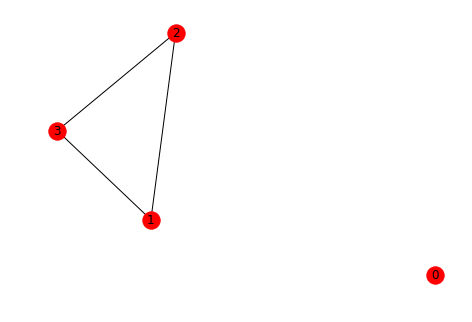

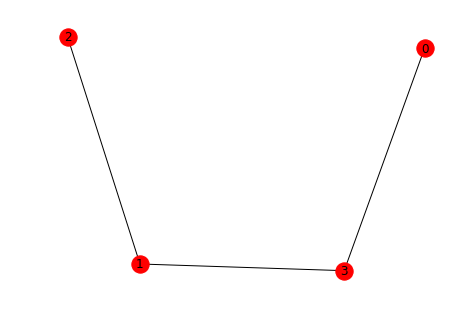

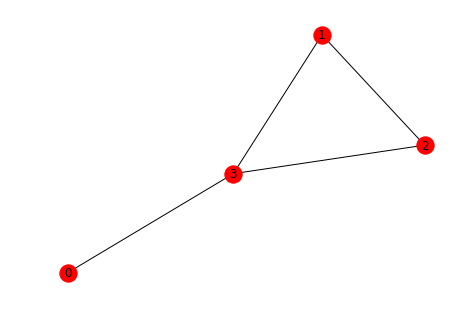

In [105]:
import matplotlib.pyplot as plt
nx.draw(geo_graph)
plt.show()
nx.draw(mst_graph)
plt.show()
nx.draw(combined_graph,data = True)
plt.show()

In [106]:
length = nx.all_pairs_shortest_path_length(combined_graph).items()
import itertools

In [107]:
def pairwise(iterable):
  """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
  a, b = itertools.tee(iterable)
  next(b, None)
  return zip(a, b)

def set_diff(seq0, seq1):
  """Return the set difference between 2 sequences as a list."""
  return list(set(seq0) - set(seq1))

[(0, 1), (1, 2), (3, 2), (1, 3), (3, 0), (3, 1), (2, 1), (0, 2), (2, 0), (2, 3), (1, 0), (0, 3)]
Counter({1: 8, 2: 4})
start:  3 end:  2
path:  [3, 2]


/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:121: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:500: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:521: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color)==1:
/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:700: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/U

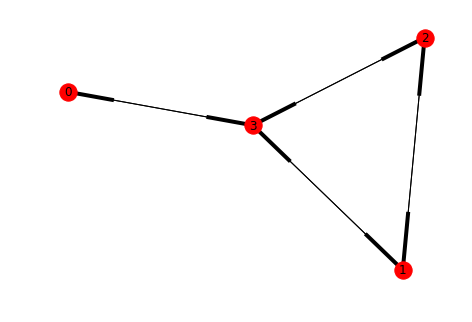

In [108]:
pair_to_length_dict = {}
try:
# This is for compatibility with older networkx.
    lengths = nx.all_pairs_shortest_path_length(combined_graph).items()
except AttributeError:
# This is for compatibility with newer networkx.
    lengths = list(nx.all_pairs_shortest_path_length(combined_graph))
for x, yy in lengths:
    for y, l in yy.items():
      if l >= 1:
        pair_to_length_dict[x, y] = l
if max(pair_to_length_dict.values()) < 1:
    raise ValueError("All shortest paths are below the minimum length")
# The node pairs which exceed the minimum length.
node_pairs = list(pair_to_length_dict)
print(node_pairs)
# Computes probabilities per pair, to enforce uniform sampling of each
# shortest path lengths.
# The counts of pairs per length.
counts = collections.Counter(pair_to_length_dict.values())
print(counts)
prob_per_length = 1.0 / len(counts)
probabilities = [
  prob_per_length / counts[pair_to_length_dict[x]] for x in node_pairs
]
i = rand.choice(len(node_pairs), p=probabilities)
start, end = node_pairs[i]
print('start: ',start,'end: ',end)
path = nx.shortest_path(
  combined_graph, source=start, target=end, weight=DISTANCE_WEIGHT_NAME)
print('path: ', path)
# Creates a directed graph, to store the directed path from start to end.
digraph = combined_graph.to_directed()
nx.draw(digraph)
# Add the "start", "end", and "solution" attributes to the nodes and edges.
digraph.add_node(start, start=True)
digraph.add_node(end, end=True)
digraph.add_nodes_from(set_diff(digraph.nodes(), [start]), start=False)
digraph.add_nodes_from(set_diff(digraph.nodes(), [end]), end=False)
digraph.add_nodes_from(set_diff(digraph.nodes(), path), solution=False)
digraph.add_nodes_from(path, solution=True)
path_edges = list(pairwise(path))
digraph.add_edges_from(set_diff(digraph.edges(), path_edges), solution=False)
digraph.add_edges_from(path_edges, solution=True)

/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:121: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:500: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:521: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color)==1:
/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:700: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/U

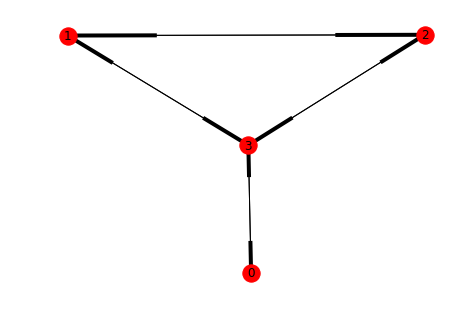

In [109]:
nx.draw(digraph)
plt.show()

In [110]:
def to_one_hot(indices, max_value, axis=-1):
  one_hot = np.eye(max_value)[indices]
  if axis not in (-1, one_hot.ndim):
    one_hot = np.moveaxis(one_hot, -1, axis)
  return one_hot


def get_node_dict(graph, attr):
  """Return a `dict` of node:attribute pairs from a graph."""
  return {k: v[attr] for k, v in graph.node.items()}
def graph_to_input_target(graph):
  """Returns 2 graphs with input and target feature vectors for training.

  Args:
    graph: An `nx.DiGraph` instance.

  Returns:
    The input `nx.DiGraph` instance.
    The target `nx.DiGraph` instance.

  Raises:
    ValueError: unknown node type
  """

  def create_feature(attr, fields):
    return np.hstack([np.array(attr[field], dtype=float) for field in fields])

  input_node_fields = ("pos", "weight", "start", "end")
  input_edge_fields = ("distance",)
  target_node_fields = ("solution",)
  target_edge_fields = ("solution",)

  input_graph = graph.copy()
  target_graph = graph.copy()

  solution_length = 0
  for node_index, node_feature in graph.nodes(data=True):
    input_graph.add_node(
        node_index, features=create_feature(node_feature, input_node_fields))
    target_node = to_one_hot(
        create_feature(node_feature, target_node_fields).astype(int), 2)[0]
    target_graph.add_node(node_index, features=target_node)
    solution_length += int(node_feature["solution"])
  solution_length /= graph.number_of_nodes()

  for receiver, sender, features in graph.edges(data=True):
    input_graph.add_edge(
        sender, receiver, features=create_feature(features, input_edge_fields))
    target_edge = to_one_hot(
        create_feature(features, target_edge_fields).astype(int), 2)[0]
    target_graph.add_edge(sender, receiver, features=target_edge)

  input_graph.graph["features"] = np.array([0.0])
  target_graph.graph["features"] = np.array([solution_length], dtype=float)

  return input_graph, target_graph

In [116]:
input_graph,target_graph = graph_to_input_target(digraph)
# input_graph.edge
target_graph.edges

{0: {3: {'distance': 0.44011235595489956,
   'features': array([1., 0.]),
   'solution': False}},
 1: {2: {'distance': 0.25612732176293496,
   'features': array([1., 0.]),
   'solution': False},
  3: {'distance': 0.19109930874428313,
   'features': array([1., 0.]),
   'solution': False}},
 2: {1: {'distance': 0.25612732176293496,
   'features': array([1., 0.]),
   'solution': False},
  3: {'distance': 0.25628507489994234,
   'features': array([0., 1.]),
   'solution': False}},
 3: {0: {'distance': 0.44011235595489956,
   'features': array([1., 0.]),
   'solution': False},
  1: {'distance': 0.19109930874428313,
   'features': array([1., 0.]),
   'solution': False},
  2: {'distance': 0.25628507489994234,
   'features': array([1., 0.]),
   'solution': True}}}

In [52]:
tf_data = tf.constant([[1.0,2.0,3.0],[4.0,5.0,6.0]],dtype = tf.float32)
print(tf_data.get_shape())
output = snt.Linear(output_size = 20)
snt.Sequential([output])
out = output(tf_data)
print(out)

(2, 3)
Tensor("linear_6/add:0", shape=(2, 20), dtype=float32)
